In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/DB/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [7]:
device = 'cpu'

train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

train_df.head()

train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

image_ids = train_df['image_id'].unique()
train_ids = image_ids[:10]
train_df = train_df[train_df['image_id'].isin(train_ids)]
def collate_fn(batch):
    return tuple(zip(*batch))

# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.Rotate(limit=80),
        A.Rotate(limit=35, p=0.9),
        A.RandomRotate90(p=0.25),
        A.RandomBrightnessContrast(p=0.85),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

class WheatDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes.astype(np.float32)
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]
    

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [62]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()

In [93]:
def draw_img_with_bbox(img, boxes):
    temp = np.copy(img)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for box in boxes:
        print(box)
        cv2.rectangle(temp,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)

    ax.set_axis_off()
    ax.imshow(temp)

In [64]:
bbox_params= A.BboxParams(
    format="pascal_voc",
    label_fields=["labels"]
)

In [ ]:
bbox_params = A.BboxParams(
  format='pascal_voc',
  min_area=1,
  min_visibility=0.5,
  label_fields=['field_id']
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


obx 580
obx 46
obx 637
obx 112
obx 493
obx 668
obx 601
obx 810
obx 400
obx 563
obx 576
obx 698
obx 609
obx 0
obx 752
obx 88
obx 893
obx 682
obx 1024
obx 844
obx 454
obx 297
obx 605
obx 452
obx 550
obx 892
obx 626
obx 985
obx 533
obx 208
obx 653
obx 350
obx 582
obx 479
obx 685
obx 575
obx 471
obx 0
obx 588
obx 32
obx 943
obx 646
obx 1024
obx 816
obx 627
obx 914
obx 688
obx 975
obx 970
obx 583
obx 1024
obx 725
obx 882
obx 282
obx 1012
obx 420
obx 462
obx 85
obx 597
obx 232
obx 769
obx 241
obx 911
obx 349
obx 765
obx 638
obx 886
obx 780
obx 315
obx 503
obx 423
obx 637
obx 412
obx 730
obx 527
obx 864
obx 220
obx 905
obx 319
obx 1024
obx 305
obx 243
obx 386
obx 342
obx 167
obx 850
obx 227
obx 908
obx 927
obx 431
obx 1015
obx 512
obx 85
obx 390
obx 192
obx 522
obx 296
obx 705
obx 394
obx 804
obx 531
obx 785
obx 625
obx 882
obx 0
obx 340
obx 106
obx 442
obx 690
obx 227
obx 924
obx 389
obx 702
obx 640
obx 872
obx 795
obx 830
obx 693
obx 933
obx 800
obx 538
obx 297
obx 647
obx 405
obx 563
obx 8

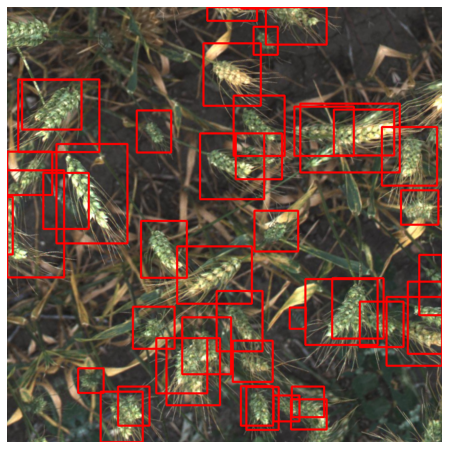

In [65]:
draw_img_with_bbox(sample, boxes)

In [68]:
aug = A.Compose(
    [
        A.Flip(always_apply=True),
    ],
    bbox_params=bbox_params
)

In [90]:
result = aug(image=sample, bboxes=boxes, labels=['5'])
image = result["image"]
bboxes = result["bboxes"]

print("result", result)
print("image", image.shape)
print("bboxes", bboxes)

result {'image': array([[[0.19534214, 0.18772271, 0.19153242],
        [0.20379494, 0.19617552, 0.19998522],
        [0.20105669, 0.19343728, 0.197247  ],
        ...,
        [0.23773266, 0.27642506, 0.2304183 ],
        [0.22343877, 0.2558809 , 0.2177242 ],
        [0.22359131, 0.2474876 , 0.21741912]],

       [[0.19483244, 0.18721302, 0.19102272],
        [0.20111623, 0.1934968 , 0.1973065 ],
        [0.19303547, 0.18541604, 0.18922575],
        ...,
        [0.28196853, 0.31264713, 0.25713092],
        [0.24591759, 0.27628368, 0.23091684],
        [0.22638535, 0.25373793, 0.221147  ]],

       [[0.19194911, 0.18432969, 0.1881394 ],
        [0.19354145, 0.18592201, 0.18973173],
        [0.1923137 , 0.18469428, 0.18850398],
        ...,
        [0.27418536, 0.3061215 , 0.2436779 ],
        [0.26070255, 0.29118028, 0.24189208],
        [0.24912462, 0.27821833, 0.24031462]],

       ...,

       [[0.26606   , 0.22254589, 0.17468634],
        [0.26095554, 0.21500087, 0.16833186],
     

In [91]:
bboxes = [ np.array(bs, dtype=np.int32) for bs in bboxes]
print(bboxes)

[array([580, 912, 637, 978], dtype=int32)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[580 912 637 978]


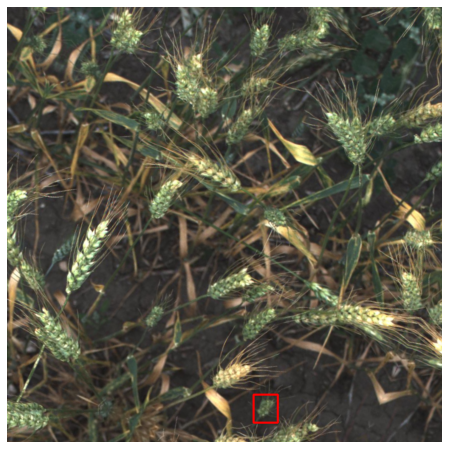

In [94]:
draw_img_with_bbox(image, bboxes)